In [1]:
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import rcParams
plt.rcParams['xtick.labelsize']  = 18
plt.rcParams['ytick.labelsize']  = 18
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family']      = 'STIXGeneral'
plt.rcParams['axes.labelsize']   = 20
plt.rcParams['axes.titlesize']   = 20
plt.rcParams['font.size']        = 10
plt.rcParams['legend.fontsize']  = 20
plt.rcParams.update({'figure.autolayout': True})
#import scienceplots
#plt.style.use(['science','ieee'])

from tqdm import tqdm
import random
import os
import time
import h5py
from datetime import datetime


import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Conv2DTranspose

# Import auxiliary libraries

import auxLib; importlib.reload(auxLib)

Importing library...
Library successfully imported
Importing library...
Library successfully imported


<module 'auxLib' from 'd:\\Facultad\\Doctorado\\Proyectos\\paper\\auxLib.py'>

In this notebook we will use a different criteria to determine the critical temperature of the system. In this case we will use the value of the temperature at which the height of every curve is the half of the total height. We will explain what this means later.

# Main variables

In [2]:
L = 40

densities = [0.55, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.7, 0.8, 0.9, 1.0]

densities_str = ['055','06', '061', '062', '063', '064', '065', '07', '08', '09','1']

first_neurons = [i for i in range(1,11)]
middle_neurons = [20 * i for i in range(1,6)]
last_neurons = [50 * i for i in range(3,21)]

neurons = first_neurons + middle_neurons + last_neurons

seed = 15

callbacks = auxLib.myCallback() # to be able to stop training if accuracy is high enough

# we will get the results from results folder

modelsfolder, resultsfolder = auxLib.folders(directory='2024-08-18',training=['all']) 

# Folder where results will be saved

saving_folder = os.path.join(os.getcwd(), 'DNN', 'Half-height', datetime.now().strftime('%Y-%m-%d'), 'training_all')

os.makedirs(saving_folder, exist_ok = True)


In [3]:
from scipy.optimize import curve_fit # We will use scipy to determine the critical temperature

# The method

We will load the predictions of 2024-08-18 and will calculate the temperature with them. To do so, we will make a copy of the predictions in our current directory ('resultsfolder') and then we will work with them.

Here is how

In [4]:
prediction = pd.read_csv(resultsfolder+f'/predictions_1.csv', header=0).to_numpy(float)

temperature, para, ferro, neel, stripe = prediction[1:].T

def constant_func(x, b):
    return np.full_like(x, b)

index_temp_1 = np.where(temperature == 1)[0][0]

index_temp_3 = np.where(temperature == 3)[0][0]

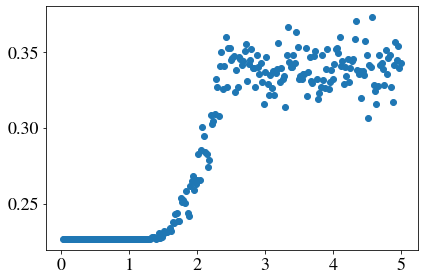

In [5]:
plt.scatter(temperature, para)

We make a linear fit on (0,1) and another linear fit on (3,5)

In [6]:
popt_first, pcov_first = curve_fit(constant_func, temperature[:index_temp_1+1], para[:index_temp_1+1])
popt_last, pcov_last = curve_fit(constant_func, temperature[index_temp_3:], para[index_temp_3:])

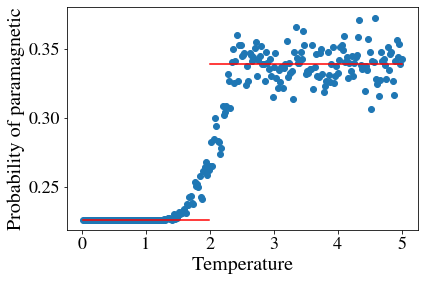

In [7]:
plt.scatter(temperature, para)

# Plot the first segment fit
plt.plot(temperature[:(np.where(temperature == 2)[0][0])], 
         constant_func(temperature[:(np.where(temperature == 2)[0][0])], *popt_first), color='red', label='First Segment Fit (Temp=1)')

# Plot the last segment fit
plt.plot(temperature[(np.where(temperature == 2)[0][0]):], 
         constant_func(temperature[(np.where(temperature == 2)[0][0]):], *popt_last), color='red', label='Last Segment Fit')

plt.xlabel('Temperature')
plt.ylabel('Probability of paramagnetic')

plt.show()

In [8]:
print(f'Lower bound: {popt_first[0]}')
print(f'Higher bound: {popt_last[0]}')

half_of_height = (popt_first[0]+popt_last[0])/2

closest_index = np.abs(para - half_of_height).argmin()
closest_x = temperature[closest_index]

print(f'Half height: {half_of_height}')
print(f'Critical temperature: {closest_x}')

Lower bound: 0.2268029004335403
Higher bound: 0.3388701340939739
Half height: 0.2828365172637571
Critical temperature: 2.14


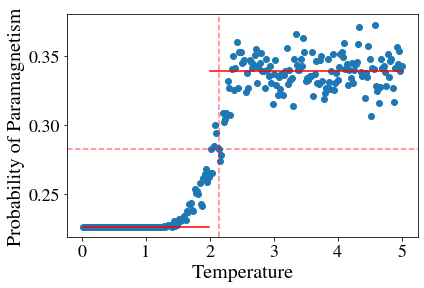

In [9]:
plt.scatter(temperature, para)

# Plot the first segment fit
plt.plot(temperature[:(np.where(temperature == 2)[0][0])], 
         constant_func(temperature[:(np.where(temperature == 2)[0][0])], *popt_first), color='red', label='First Segment Fit (Temp=1)')

# Plot the last segment fit
plt.plot(temperature[(np.where(temperature == 2)[0][0]):], 
         constant_func(temperature[(np.where(temperature == 2)[0][0]):], *popt_last), color='red', label='Last Segment Fit')

plt.axhline(y=half_of_height, color = 'red', linestyle = '--', alpha = 0.5)

plt.axvline(x=closest_x, color = 'red', linestyle = '--', alpha = 0.5)

plt.xlabel('Temperature')
plt.ylabel('Probability of Paramagnetism')

plt.show()

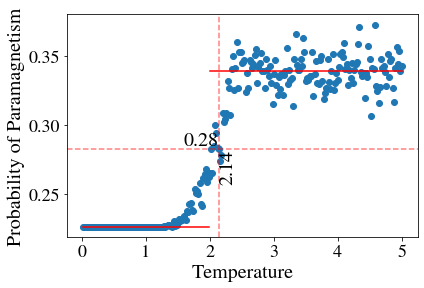

In [10]:
plt.scatter(temperature, para)

# Plot the first segment fit
plt.plot(temperature[:(np.where(temperature == 2)[0][0])], 
         constant_func(temperature[:(np.where(temperature == 2)[0][0])], *popt_first), color='red', label='First fit')

# Plot the last segment fit
plt.plot(temperature[(np.where(temperature == 2)[0][0]):], 
         constant_func(temperature[(np.where(temperature == 2)[0][0]):], *popt_last), color='red', label='Last fit')

# Add horizontal and vertical lines
plt.axhline(y=half_of_height, color='red', linestyle='--', alpha=0.5)
plt.axvline(x=closest_x, color='red', linestyle='--', alpha=0.5)

# Display the value of half_of_height on the y-axis
plt.text(closest_x, half_of_height, f'{half_of_height:.2f}', color='black', 
        verticalalignment='bottom', horizontalalignment='right', fontsize=20)
plt.text(closest_x, half_of_height, f'{closest_x:.2f}', color='black', 
        verticalalignment='top', horizontalalignment='left', rotation=90, fontsize=20)

# Add labels and legend
plt.xlabel('Temperature')
plt.ylabel('Probability of Paramagnetism')

# Adjust legend position
#plt.legend(loc='upper left')  # Change the location as needed

# Show the plot
plt.show()


# Critical temperature per prediction

Lower bound: 0.2268029004335403
Higher bound: 0.3388701340939739
Half height: 0.2828365172637571
Critical temperature: 2.14
Lower bound: 0.3187930881977081
Higher bound: 0.22151429420060448
Half height: 0.2701536911991563
Critical temperature: 2.12
Lower bound: 0.1316035538911819
Higher bound: 0.2132752562791358
Half height: 0.17243940508515884
Critical temperature: 2.06
Lower bound: 0.3228006064891815
Higher bound: 0.22634073250785935
Half height: 0.27457066949852044
Critical temperature: 2.06


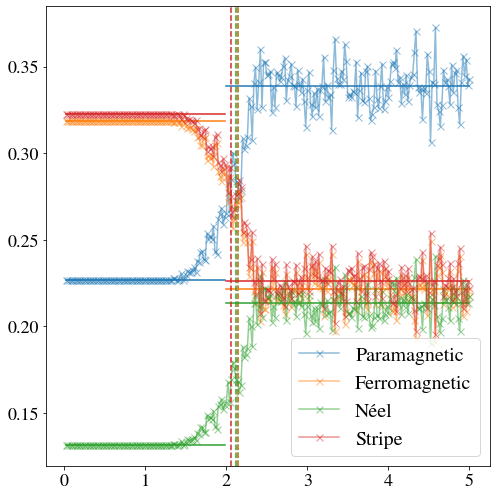

In [11]:
prediction = pd.read_csv(resultsfolder+f'/predictions_1.csv', header=0).to_numpy(float)

temperature, para, ferro, neel, stripe = prediction[1:].T

def constant_func(x, b):
    return np.full_like(x, b)

index_temp_1 = np.where(temperature == 1)[0][0]

index_temp_3 = np.where(temperature == 3)[0][0]

linear_fitting = []
tc = []

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(7, 7))

names = ['Paramagnetic', 'Ferromagnetic', 'Néel', 'Stripe']

for index, feature in enumerate([para, ferro, neel, stripe]):
    color = colors[index]
    
    plt.plot(temperature, feature, 'x-', markerfacecolor=None, markersize=7, label = f'{names[index]}', color=color, alpha=0.5)

    popt_first, pcov_first = curve_fit(constant_func, temperature[:index_temp_1+1], feature[:index_temp_1+1])
    popt_last, pcov_last = curve_fit(constant_func, temperature[index_temp_3:], feature[index_temp_3:])

    plt.plot(temperature[:(np.where(temperature == 2)[0][0])], 
         constant_func(temperature[:(np.where(temperature == 2)[0][0])], *popt_first), color=color)

    plt.plot(temperature[(np.where(temperature == 2)[0][0]):], 
         constant_func(temperature[(np.where(temperature == 2)[0][0]):], *popt_last), color=color)
    plt.axvline(x=closest_x, color = color, linestyle = '--')
    
    print(f'Lower bound: {popt_first[0]}')
    print(f'Higher bound: {popt_last[0]}')
    
    half_of_height = (popt_first[0]+popt_last[0])/2
    closest_index = np.abs(feature - half_of_height).argmin()
    closest_x = temperature[closest_index]
    
    print(f'Half height: {half_of_height}')
    print(f'Critical temperature: {closest_x}')
    linear_fitting.append([popt_first[0], popt_last[0]])
    tc.append(closest_x)
    
plt.legend()
plt.show()

# Doing this for every DNN

In [12]:
def constant_func(x, b):
    return np.full_like(x, b)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

names = ['Paramagnetic', 'Ferromagnetic', 'Néel', 'Stripe']

Prediction for 1 neurons in hidden layer
Lower bound (Paramagnetic): 0.2268029004335403
Higher bound (Paramagnetic): 0.34067877718046596
Half height (Paramagnetic): 0.2837408388070031
Critical temperature (Paramagnetic): 2.12
Lower bound (Ferromagnetic): 0.3187930881977081
Higher bound (Ferromagnetic): 0.2198801251001734
Half height (Ferromagnetic): 0.26933660664894077
Critical temperature (Ferromagnetic): 2.06
Lower bound (Néel): 0.1316035538911819
Higher bound (Néel): 0.2147932216215772
Half height (Néel): 0.17319838775637955
Critical temperature (Néel): 2.1
Lower bound (Stripe): 0.3228006064891815
Higher bound (Stripe): 0.2246483026749393
Half height (Stripe): 0.2737244545820604
Critical temperature (Stripe): 2.06


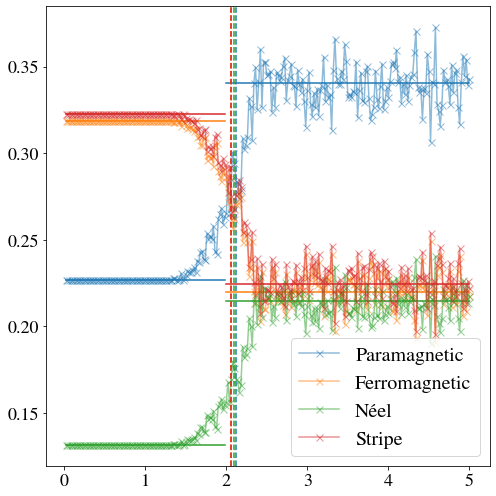

Prediction for 2 neurons in hidden layer
Lower bound (Paramagnetic): 0.11552744299173351
Higher bound (Paramagnetic): 0.3981892846378625
Half height (Paramagnetic): 0.256858363814798
Critical temperature (Paramagnetic): 2.28
Lower bound (Ferromagnetic): 0.6049955368041993
Higher bound (Ferromagnetic): 0.20890103222108353
Half height (Ferromagnetic): 0.4069482845126414
Critical temperature (Ferromagnetic): 2.3000000000000003
Lower bound (Néel): 0.0854227766394615
Higher bound (Néel): 0.18068369813815177
Half height (Néel): 0.13305323738880664
Critical temperature (Néel): 2.84
Lower bound (Stripe): 0.1940547525882721
Higher bound (Stripe): 0.21222556163282952
Half height (Stripe): 0.2031401571105508
Critical temperature (Stripe): 3.6


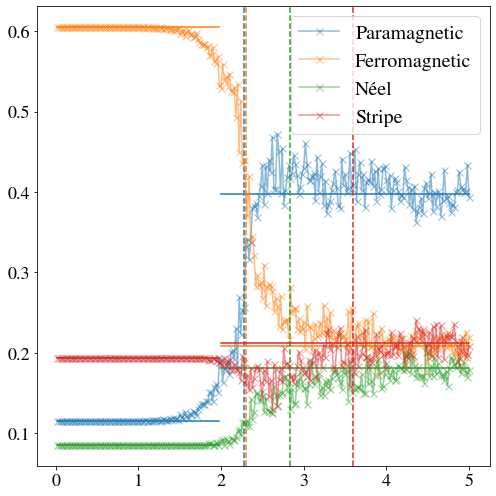

Prediction for 3 neurons in hidden layer
Lower bound (Paramagnetic): 0.1833196297287941
Higher bound (Paramagnetic): 0.4317600095960903
Half height (Paramagnetic): 0.3075398196624422
Critical temperature (Paramagnetic): 2.2
Lower bound (Ferromagnetic): 0.46845143914222714
Higher bound (Ferromagnetic): 0.23831628087522738
Half height (Ferromagnetic): 0.35338386000872724
Critical temperature (Ferromagnetic): 2.18
Lower bound (Néel): 0.2495940348505974
Higher bound (Néel): 0.18359378505977508
Half height (Néel): 0.21659390995518624
Critical temperature (Néel): 2.24
Lower bound (Stripe): 0.09863579764962195
Higher bound (Stripe): 0.14633025331053817
Half height (Stripe): 0.12248302548008005
Critical temperature (Stripe): 2.26


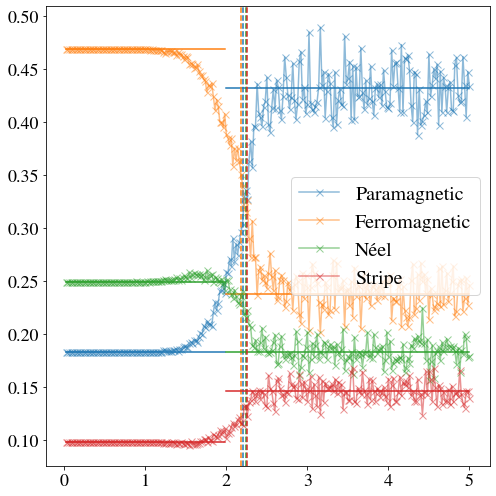

Prediction for 4 neurons in hidden layer
Lower bound (Paramagnetic): 0.0810406059026718
Higher bound (Paramagnetic): 0.4339752308281538
Half height (Paramagnetic): 0.2575079183654128
Critical temperature (Paramagnetic): 2.4
Lower bound (Ferromagnetic): 0.632330596446991
Higher bound (Ferromagnetic): 0.24002352970487928
Half height (Ferromagnetic): 0.4361770630759351
Critical temperature (Ferromagnetic): 2.54
Lower bound (Néel): 0.030046310275793
Higher bound (Néel): 0.0767016623368173
Half height (Néel): 0.053373986306305146
Critical temperature (Néel): 2.54
Lower bound (Stripe): 0.2565827667713165
Higher bound (Stripe): 0.24929952007882733
Half height (Stripe): 0.2529411434250719
Critical temperature (Stripe): 1.62


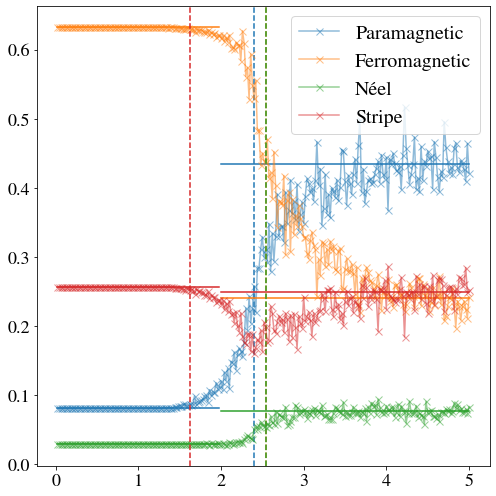

Prediction for 5 neurons in hidden layer
Lower bound (Paramagnetic): 0.00023119238991053002
Higher bound (Paramagnetic): 0.4538560994687977
Half height (Paramagnetic): 0.2270436459293541
Critical temperature (Paramagnetic): 2.38
Lower bound (Ferromagnetic): 0.9665023684500917
Higher bound (Ferromagnetic): 0.08094062641354682
Half height (Ferromagnetic): 0.5237214974318193
Critical temperature (Ferromagnetic): 2.32
Lower bound (Néel): 0.03320379272103305
Higher bound (Néel): 0.2560661017294157
Half height (Néel): 0.14463494722522435
Critical temperature (Néel): 2.26
Lower bound (Stripe): 6.295707222307099e-05
Higher bound (Stripe): 0.20913715894143226
Half height (Stripe): 0.10460005800682766
Critical temperature (Stripe): 2.42


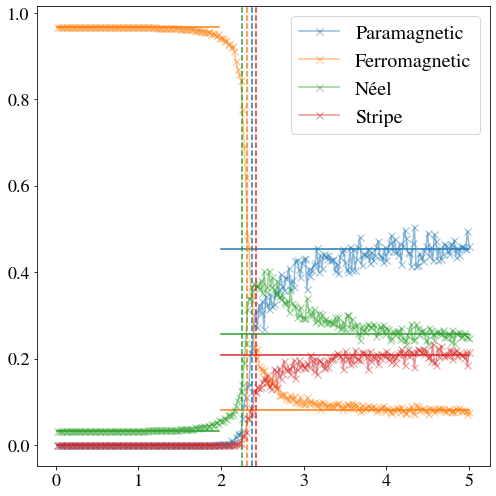

Prediction for 6 neurons in hidden layer
Lower bound (Paramagnetic): 0.001891353344544716
Higher bound (Paramagnetic): 0.6649655688042734
Half height (Paramagnetic): 0.33342846107440904
Critical temperature (Paramagnetic): 2.38
Lower bound (Ferromagnetic): 0.9677438354491484
Higher bound (Ferromagnetic): 0.10503731171094854
Half height (Ferromagnetic): 0.5363905735800485
Critical temperature (Ferromagnetic): 2.36
Lower bound (Néel): 1.5273504700969685e-08
Higher bound (Néel): 0.13963930980831965
Half height (Néel): 0.06981966254091218
Critical temperature (Néel): 2.44
Lower bound (Stripe): 0.030365015603601882
Higher bound (Stripe): 0.09035789484288437
Half height (Stripe): 0.06036145522324313
Critical temperature (Stripe): 2.24


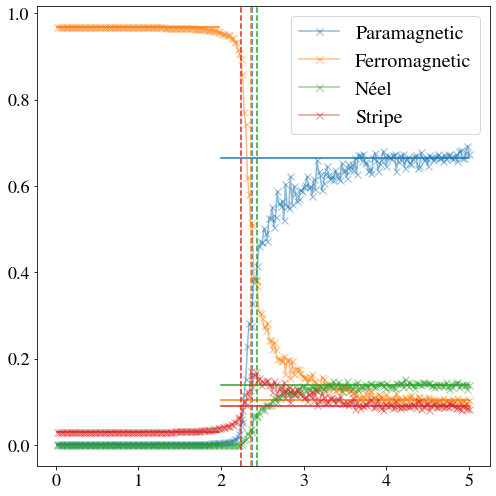

Prediction for 7 neurons in hidden layer
Lower bound (Paramagnetic): 0.00014068262447830798
Higher bound (Paramagnetic): 0.6100779374432005
Half height (Paramagnetic): 0.3051093100338394
Critical temperature (Paramagnetic): 2.32
Lower bound (Ferromagnetic): 0.9998586177825926
Higher bound (Ferromagnetic): 0.03265500868295246
Half height (Ferromagnetic): 0.5162568132327725
Critical temperature (Ferromagnetic): 2.36
Lower bound (Néel): 1.3380288279511897e-26
Higher bound (Néel): 0.09534693509340282
Half height (Néel): 0.04767346754670141
Critical temperature (Néel): 2.72
Lower bound (Stripe): 1.7814736930527054e-27
Higher bound (Stripe): 0.2619202195413233
Half height (Stripe): 0.13096010977066164
Critical temperature (Stripe): 2.68


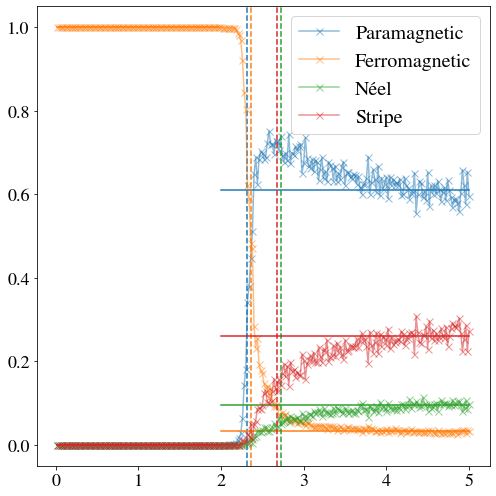

Prediction for 8 neurons in hidden layer
Lower bound (Paramagnetic): 0.022625796236097766
Higher bound (Paramagnetic): 0.5800761744078657
Half height (Paramagnetic): 0.30135098532198173
Critical temperature (Paramagnetic): 2.3000000000000003
Lower bound (Ferromagnetic): 0.9773732674121857
Higher bound (Ferromagnetic): 0.14997834931216192
Half height (Ferromagnetic): 0.5636758083621738
Critical temperature (Ferromagnetic): 2.34
Lower bound (Néel): 1.3099669071736324e-10
Higher bound (Néel): 0.018441949987140105
Half height (Néel): 0.009220975059068397
Critical temperature (Néel): 2.64
Lower bound (Stripe): 7.265686452484487e-10
Higher bound (Stripe): 0.25150347924536676
Half height (Stripe): 0.1257517399859677
Critical temperature (Stripe): 2.52


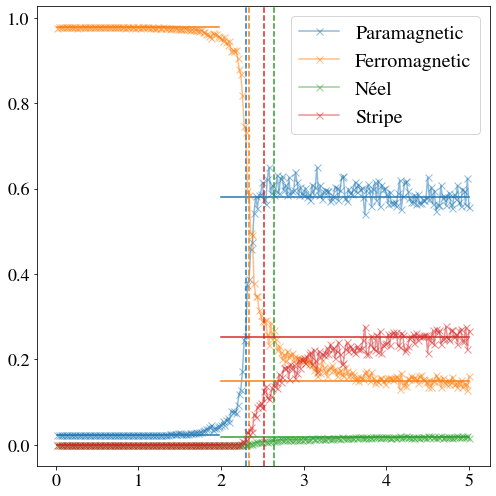

Prediction for 9 neurons in hidden layer
Lower bound (Paramagnetic): 0.013804083168506572
Higher bound (Paramagnetic): 0.5901571371976067
Half height (Paramagnetic): 0.3019806101830566
Critical temperature (Paramagnetic): 2.36
Lower bound (Ferromagnetic): 0.9831405091285338
Higher bound (Ferromagnetic): 0.15961137764410815
Half height (Ferromagnetic): 0.571375943386321
Critical temperature (Ferromagnetic): 2.38
Lower bound (Néel): 0.002434920044615814
Higher bound (Néel): 0.1052089415325016
Half height (Néel): 0.05382193078855871
Critical temperature (Néel): 2.38
Lower bound (Stripe): 0.000620470693102054
Higher bound (Stripe): 0.14502253894712408
Half height (Stripe): 0.07282150482011307
Critical temperature (Stripe): 2.36


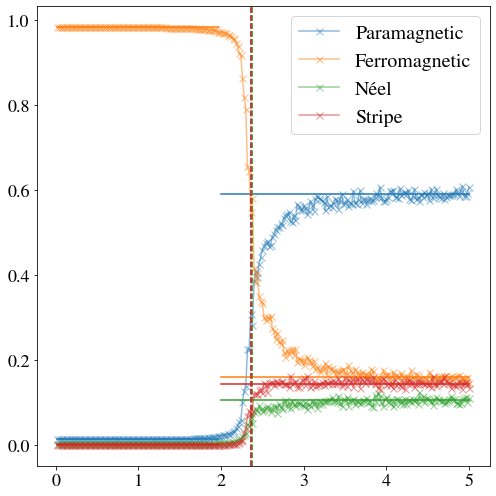

Prediction for 10 neurons in hidden layer
Lower bound (Paramagnetic): 1.9126912462752064e-07
Higher bound (Paramagnetic): 0.7400154214279324
Half height (Paramagnetic): 0.37000780634852853
Critical temperature (Paramagnetic): 2.44
Lower bound (Ferromagnetic): 0.9718760907649381
Higher bound (Ferromagnetic): 0.0885044473643396
Half height (Ferromagnetic): 0.5301902690646388
Critical temperature (Ferromagnetic): 2.4
Lower bound (Néel): 0.028123690411448438
Higher bound (Néel): 0.11183073809918231
Half height (Néel): 0.06997721425531538
Critical temperature (Néel): 2.22
Lower bound (Stripe): 1.3548254629249777e-09
Higher bound (Stripe): 0.05964939186678209
Half height (Stripe): 0.029824696610803773
Critical temperature (Stripe): 2.48


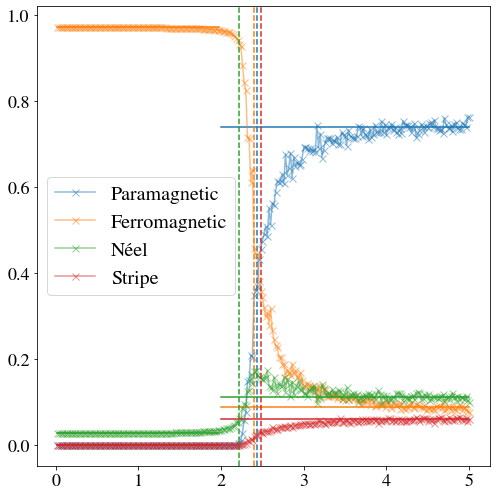

Prediction for 20 neurons in hidden layer
Lower bound (Paramagnetic): 0.00042276324238623797
Higher bound (Paramagnetic): 0.773746506840575
Half height (Paramagnetic): 0.3870846350414806
Critical temperature (Paramagnetic): 2.4
Lower bound (Ferromagnetic): 0.999577386379241
Higher bound (Ferromagnetic): 0.10524334553799175
Half height (Ferromagnetic): 0.5524103659586164
Critical temperature (Ferromagnetic): 2.4
Lower bound (Néel): 9.475145265711868e-11
Higher bound (Néel): 0.05990273885282812
Half height (Néel): 0.029951369473789784
Critical temperature (Néel): 2.54
Lower bound (Stripe): 1.194677833223079e-12
Higher bound (Stripe): 0.0611074282675953
Half height (Stripe): 0.030553714134394987
Critical temperature (Stripe): 2.64


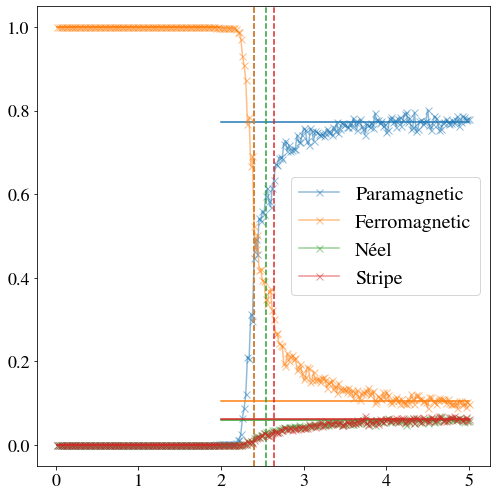

Prediction for 40 neurons in hidden layer
Lower bound (Paramagnetic): 5.8069186561624516e-05
Higher bound (Paramagnetic): 0.8824968349697317
Half height (Paramagnetic): 0.44127745207814667
Critical temperature (Paramagnetic): 2.36
Lower bound (Ferromagnetic): 0.9999406862258909
Higher bound (Ferromagnetic): 0.050035700859392344
Half height (Ferromagnetic): 0.5249881935426416
Critical temperature (Ferromagnetic): 2.36
Lower bound (Néel): 7.5101739298579e-08
Higher bound (Néel): 0.03371224888188762
Half height (Néel): 0.01685616199181346
Critical temperature (Néel): 2.4
Lower bound (Stripe): 8.589853028863346e-10
Higher bound (Stripe): 0.03375518760049645
Half height (Stripe): 0.016877594229740875
Critical temperature (Stripe): 2.42


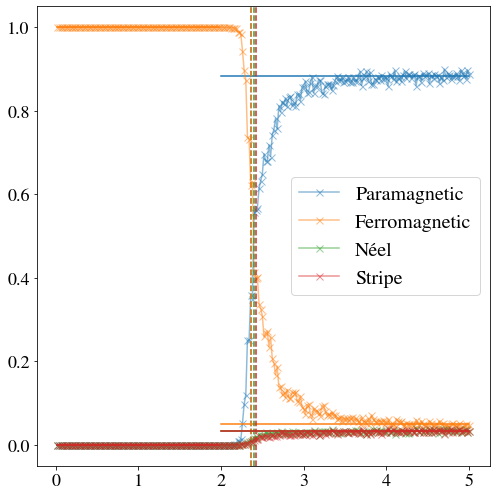

Prediction for 60 neurons in hidden layer
Lower bound (Paramagnetic): 2.3576444649917126e-14
Higher bound (Paramagnetic): 0.8537583690060436
Half height (Paramagnetic): 0.4268791845030336
Critical temperature (Paramagnetic): 2.56
Lower bound (Ferromagnetic): 0.9999993443489076
Higher bound (Ferromagnetic): 0.10220838104392964
Half height (Ferromagnetic): 0.5511038626964186
Critical temperature (Ferromagnetic): 2.56
Lower bound (Néel): 1.884125190349642e-18
Higher bound (Néel): 0.021104362955482125
Half height (Néel): 0.010552181477741064
Critical temperature (Néel): 2.74
Lower bound (Stripe): 6.317982691142097e-16
Higher bound (Stripe): 0.02292882669138685
Half height (Stripe): 0.01146441334569374
Critical temperature (Stripe): 2.6


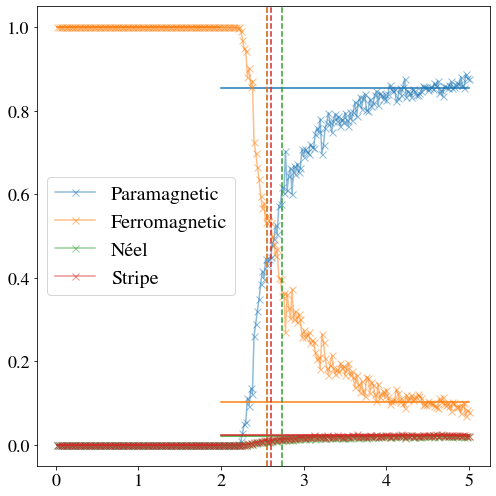

Prediction for 80 neurons in hidden layer
Lower bound (Paramagnetic): 0.000180754646426014
Higher bound (Paramagnetic): 0.8975600518430084
Half height (Paramagnetic): 0.44887040324471716
Critical temperature (Paramagnetic): 2.34
Lower bound (Ferromagnetic): 0.999816769361496
Higher bound (Ferromagnetic): 0.03988823981052292
Half height (Ferromagnetic): 0.5198525045860094
Critical temperature (Ferromagnetic): 2.34
Lower bound (Néel): 1.3832232070854042e-06
Higher bound (Néel): 0.03658530729448295
Half height (Néel): 0.018293345258845017
Critical temperature (Néel): 2.44
Lower bound (Stripe): 7.330678226935593e-07
Higher bound (Stripe): 0.025966408313409683
Half height (Stripe): 0.012983570690616189
Critical temperature (Stripe): 2.4


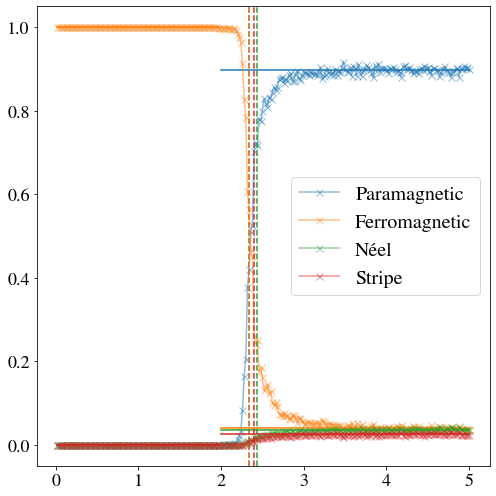

Prediction for 100 neurons in hidden layer
Lower bound (Paramagnetic): 9.380446732393466e-05
Higher bound (Paramagnetic): 0.9780495529080828
Half height (Paramagnetic): 0.4890716786877034
Critical temperature (Paramagnetic): 2.34
Lower bound (Ferromagnetic): 0.9998725843429562
Higher bound (Ferromagnetic): 0.006694380091344931
Half height (Ferromagnetic): 0.5032834822171506
Critical temperature (Ferromagnetic): 2.32
Lower bound (Néel): 2.0898245311400393e-05
Higher bound (Néel): 0.004759668760622496
Half height (Néel): 0.0023902835029669485
Critical temperature (Néel): 2.28
Lower bound (Stripe): 1.422130850187387e-05
Higher bound (Stripe): 0.010496389940413797
Half height (Stripe): 0.005255305624457835
Critical temperature (Stripe): 2.32


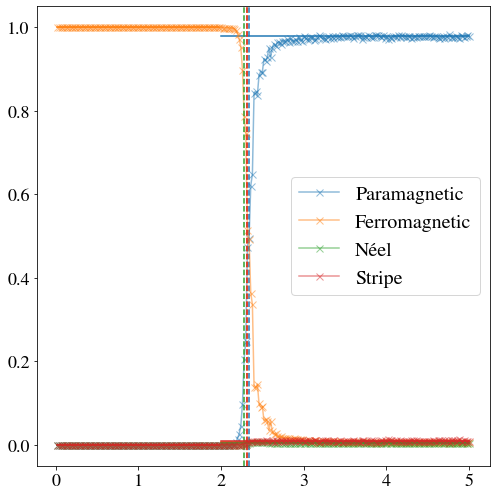

Prediction for 150 neurons in hidden layer
Lower bound (Paramagnetic): 5.095247992414902e-09
Higher bound (Paramagnetic): 0.8823031280552409
Half height (Paramagnetic): 0.44115156657524446
Critical temperature (Paramagnetic): 2.46
Lower bound (Ferromagnetic): 0.9999993443489076
Higher bound (Ferromagnetic): 0.07954851917776404
Half height (Ferromagnetic): 0.5397739317633358
Critical temperature (Ferromagnetic): 2.46
Lower bound (Néel): 4.580509695827952e-12
Higher bound (Néel): 0.01933463264768025
Half height (Néel): 0.00966731632613038
Critical temperature (Néel): 2.46
Lower bound (Stripe): 1.3018344323552367e-13
Higher bound (Stripe): 0.018813727494453536
Half height (Stripe): 0.00940686374729186
Critical temperature (Stripe): 2.54


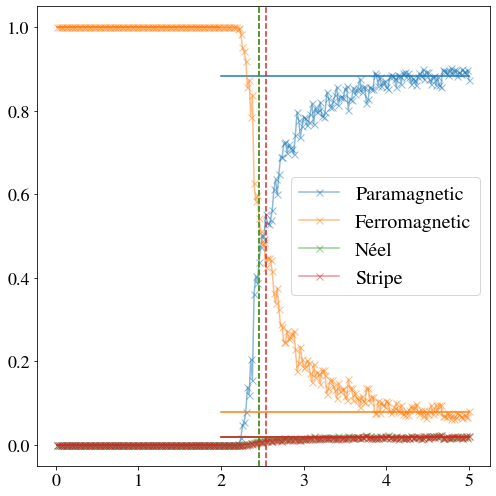

Prediction for 200 neurons in hidden layer
Lower bound (Paramagnetic): 4.959327425240198e-06
Higher bound (Paramagnetic): 0.9800889503721663
Half height (Paramagnetic): 0.49004695484979577
Critical temperature (Paramagnetic): 2.36
Lower bound (Ferromagnetic): 0.9999927866458893
Higher bound (Ferromagnetic): 0.009559070700596896
Half height (Ferromagnetic): 0.5047759286732431
Critical temperature (Ferromagnetic): 2.36
Lower bound (Néel): 1.354950921950113e-07
Higher bound (Néel): 0.0035927946538857336
Half height (Néel): 0.0017964650744889644
Critical temperature (Néel): 2.34
Lower bound (Stripe): 2.0410753040778216e-06
Higher bound (Stripe): 0.006759228054823985
Half height (Stripe): 0.003380634565064031
Critical temperature (Stripe): 2.32


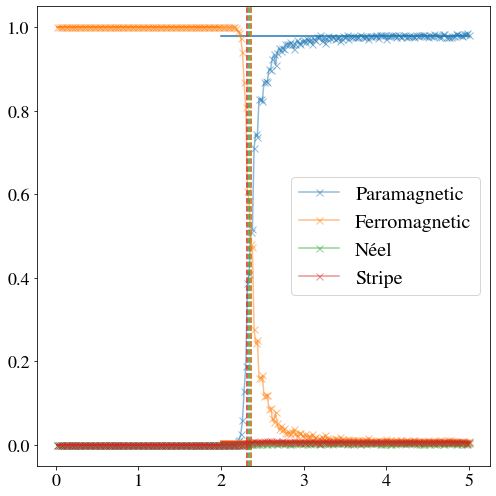

Prediction for 250 neurons in hidden layer
Lower bound (Paramagnetic): 0.000161547547322646
Higher bound (Paramagnetic): 0.980992361611011
Half height (Paramagnetic): 0.49057695457916684
Critical temperature (Paramagnetic): 2.32
Lower bound (Ferromagnetic): 0.9998259603977203
Higher bound (Ferromagnetic): 0.005656107399708232
Half height (Ferromagnetic): 0.5027410338987143
Critical temperature (Ferromagnetic): 2.32
Lower bound (Néel): 1.9299912219139367e-06
Higher bound (Néel): 0.007334599244024769
Half height (Néel): 0.0036682646176233414
Critical temperature (Néel): 2.34
Lower bound (Stripe): 1.2056766227033224e-05
Higher bound (Stripe): 0.006016885886978129
Half height (Stripe): 0.0030144713266025813
Critical temperature (Stripe): 2.3000000000000003


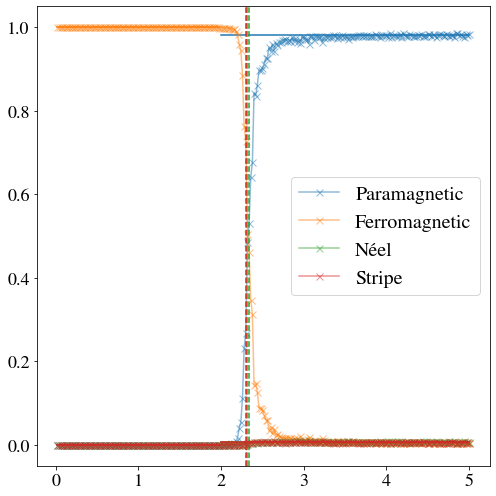

Prediction for 300 neurons in hidden layer
Lower bound (Paramagnetic): 4.653636333387107e-06
Higher bound (Paramagnetic): 0.9442059421070602
Half height (Paramagnetic): 0.4721052978716968
Critical temperature (Paramagnetic): 2.38
Lower bound (Ferromagnetic): 0.9999939548969268
Higher bound (Ferromagnetic): 0.022600592604952285
Half height (Ferromagnetic): 0.5112972737509396
Critical temperature (Ferromagnetic): 2.38
Lower bound (Néel): 1.8973190911708576e-08
Higher bound (Néel): 0.009363710305050836
Half height (Néel): 0.004681864639120874
Critical temperature (Néel): 2.36
Lower bound (Stripe): 1.6411847418851267e-08
Higher bound (Stripe): 0.0238297747463313
Half height (Stripe): 0.01191489557908936
Critical temperature (Stripe): 2.4


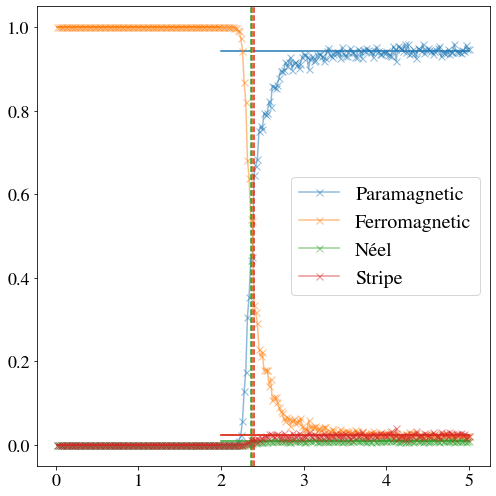

Prediction for 350 neurons in hidden layer
Lower bound (Paramagnetic): 3.3216936717508344e-05
Higher bound (Paramagnetic): 0.9909737016640457
Half height (Paramagnetic): 0.49550345930038164
Critical temperature (Paramagnetic): 2.34
Lower bound (Ferromagnetic): 0.9999583494663238
Higher bound (Ferromagnetic): 0.0029047899994723014
Half height (Ferromagnetic): 0.501431569732898
Critical temperature (Ferromagnetic): 2.34
Lower bound (Néel): 5.147630481587834e-06
Higher bound (Néel): 0.0029740188815153834
Half height (Néel): 0.0014895832559984857
Critical temperature (Néel): 2.28
Lower bound (Stripe): 4.80425854220811e-06
Higher bound (Stripe): 0.0031474532020807373
Half height (Stripe): 0.0015761287303114727
Critical temperature (Stripe): 2.28


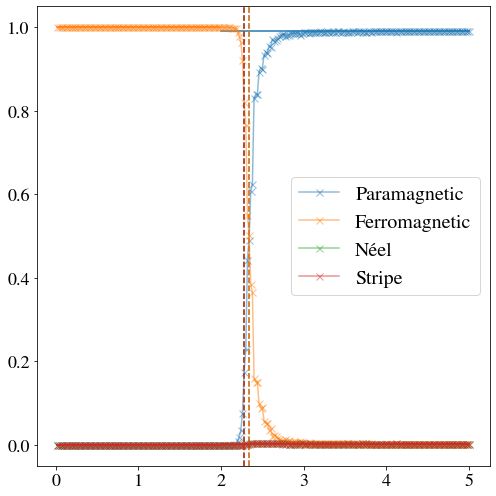

Prediction for 400 neurons in hidden layer
Lower bound (Paramagnetic): 6.306364952024524e-08
Higher bound (Paramagnetic): 0.9885406213648179
Half height (Paramagnetic): 0.4942703422142337
Critical temperature (Paramagnetic): 2.36
Lower bound (Ferromagnetic): 0.9999987483024596
Higher bound (Ferromagnetic): 0.003846414079177185
Half height (Ferromagnetic): 0.5019225811908183
Critical temperature (Ferromagnetic): 2.36
Lower bound (Néel): 9.387925173224644e-11
Higher bound (Néel): 0.0016710562997760414
Half height (Néel): 0.0008355281968276466
Critical temperature (Néel): 2.46
Lower bound (Stripe): 2.0013153009812435e-11
Higher bound (Stripe): 0.005941892347452806
Half height (Stripe): 0.0029709461837329793
Critical temperature (Stripe): 4.0


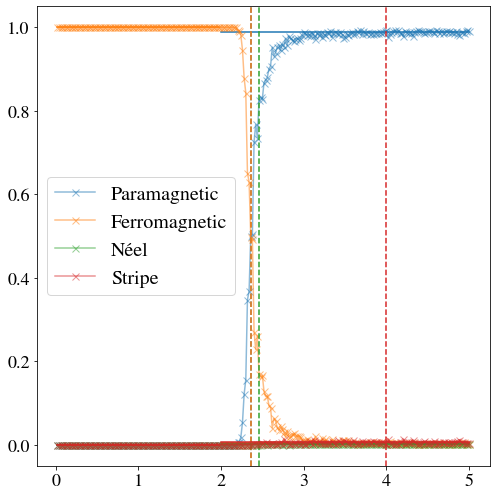

Prediction for 450 neurons in hidden layer
Lower bound (Paramagnetic): 0.000368000704911484
Higher bound (Paramagnetic): 0.9964368144671044
Half height (Paramagnetic): 0.49840240758600796
Critical temperature (Paramagnetic): 2.32
Lower bound (Ferromagnetic): 0.9995543849468221
Higher bound (Ferromagnetic): 0.0011781060670995058
Half height (Ferromagnetic): 0.5003662455069608
Critical temperature (Ferromagnetic): 2.32
Lower bound (Néel): 1.1172441572853135e-05
Higher bound (Néel): 0.0004196109389429196
Half height (Néel): 0.00021539169025788638
Critical temperature (Néel): 2.22
Lower bound (Stripe): 6.651567397057077e-05
Higher bound (Stripe): 0.0019654677701456077
Half height (Stripe): 0.0010159917220580893
Critical temperature (Stripe): 2.2


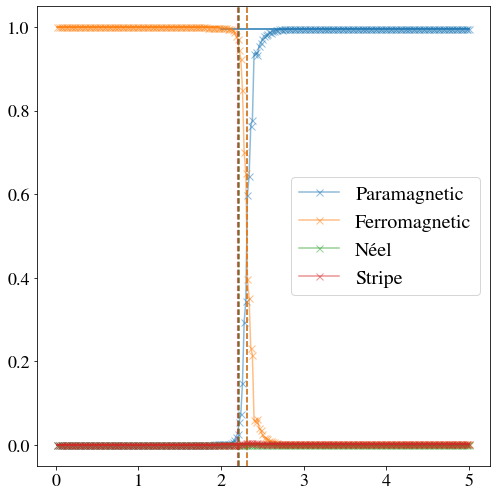

Prediction for 500 neurons in hidden layer
Lower bound (Paramagnetic): 0.00058093481231476
Higher bound (Paramagnetic): 0.9978579165888768
Half height (Paramagnetic): 0.4992194257005958
Critical temperature (Paramagnetic): 2.3000000000000003
Lower bound (Ferromagnetic): 0.9993087351322159
Higher bound (Ferromagnetic): 0.0006587858101827431
Half height (Ferromagnetic): 0.4999837604711993
Critical temperature (Ferromagnetic): 2.3000000000000003
Lower bound (Néel): 5.075329194369261e-05
Higher bound (Néel): 0.0002608979486074647
Half height (Néel): 0.00015582562027557865
Critical temperature (Néel): 2.06
Lower bound (Stripe): 6.104599735408555e-05
Higher bound (Stripe): 0.0012224111454926098
Half height (Stripe): 0.0006417285714233477
Critical temperature (Stripe): 2.18


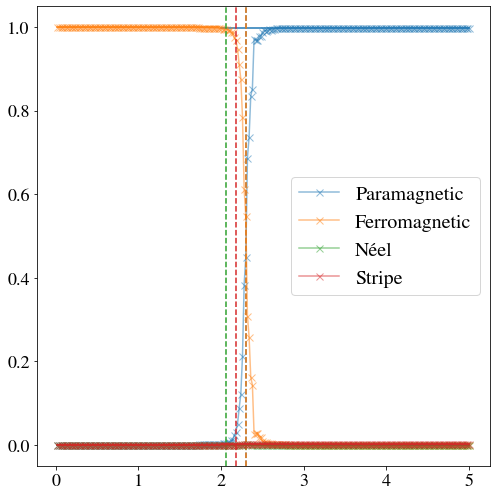

Prediction for 550 neurons in hidden layer
Lower bound (Paramagnetic): 0.00050832086591976
Higher bound (Paramagnetic): 0.9921784658057846
Half height (Paramagnetic): 0.4963433933358522
Critical temperature (Paramagnetic): 2.32
Lower bound (Ferromagnetic): 0.9994392883777606
Higher bound (Ferromagnetic): 0.0022734013869992725
Half height (Ferromagnetic): 0.50085634488238
Critical temperature (Ferromagnetic): 2.32
Lower bound (Néel): 3.561181663826574e-05
Higher bound (Néel): 0.0029809959689337294
Half height (Néel): 0.0015083038927859976
Critical temperature (Néel): 2.26
Lower bound (Stripe): 1.7063510968000637e-05
Higher bound (Stripe): 0.0025671708406697353
Half height (Stripe): 0.0012921171758188679
Critical temperature (Stripe): 2.26


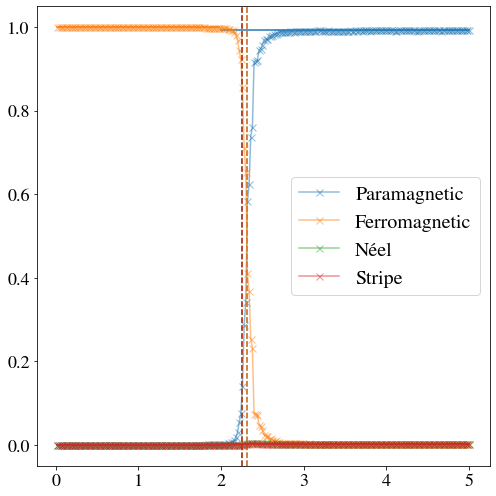

Prediction for 600 neurons in hidden layer
Lower bound (Paramagnetic): 0.00041609918465832803
Higher bound (Paramagnetic): 0.9966408002610226
Half height (Paramagnetic): 0.4985284497228405
Critical temperature (Paramagnetic): 2.3000000000000003
Lower bound (Ferromagnetic): 0.9993093240261063
Higher bound (Ferromagnetic): 0.0007709831366881117
Half height (Ferromagnetic): 0.5000401535813972
Critical temperature (Ferromagnetic): 2.3000000000000003
Lower bound (Néel): 4.164475372817833e-05
Higher bound (Néel): 0.0006597586371022373
Half height (Néel): 0.0003507016954152078
Critical temperature (Néel): 2.16
Lower bound (Stripe): 0.000232993600657156
Higher bound (Stripe): 0.0019284474216035804
Half height (Stripe): 0.0010807205111303681
Critical temperature (Stripe): 2.12


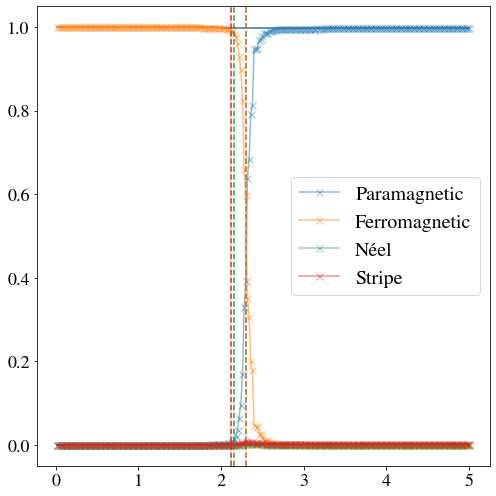

Prediction for 650 neurons in hidden layer
Lower bound (Paramagnetic): 0.001733652499969996
Higher bound (Paramagnetic): 0.9769977599966759
Half height (Paramagnetic): 0.489365706248323
Critical temperature (Paramagnetic): 2.32
Lower bound (Ferromagnetic): 0.9982474935054779
Higher bound (Ferromagnetic): 0.008825113138585658
Half height (Ferromagnetic): 0.5035363033220318
Critical temperature (Ferromagnetic): 2.32
Lower bound (Néel): 1.670315188675887e-05
Higher bound (Néel): 0.006900753186759937
Half height (Néel): 0.003458728169323348
Critical temperature (Néel): 2.32
Lower bound (Stripe): 1.9992873967566974e-06
Higher bound (Stripe): 0.007276418591465969
Half height (Stripe): 0.0036392089394313627
Critical temperature (Stripe): 2.58


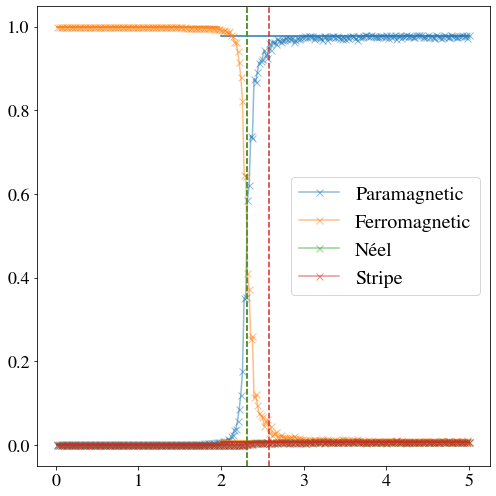

Prediction for 700 neurons in hidden layer
Lower bound (Paramagnetic): 0.001496787110809192
Higher bound (Paramagnetic): 0.958136040790317
Half height (Paramagnetic): 0.47981641395056307
Critical temperature (Paramagnetic): 2.32
Lower bound (Ferromagnetic): 0.9984685885906186
Higher bound (Ferromagnetic): 0.013076313276101037
Half height (Ferromagnetic): 0.5057724509333599
Critical temperature (Ferromagnetic): 2.32
Lower bound (Néel): 1.1897860003955433e-05
Higher bound (Néel): 0.010060294921742874
Half height (Néel): 0.005036096390873415
Critical temperature (Néel): 2.38
Lower bound (Stripe): 2.17602596967481e-05
Higher bound (Stripe): 0.018727368782598952
Half height (Stripe): 0.00937456452114785
Critical temperature (Stripe): 2.38


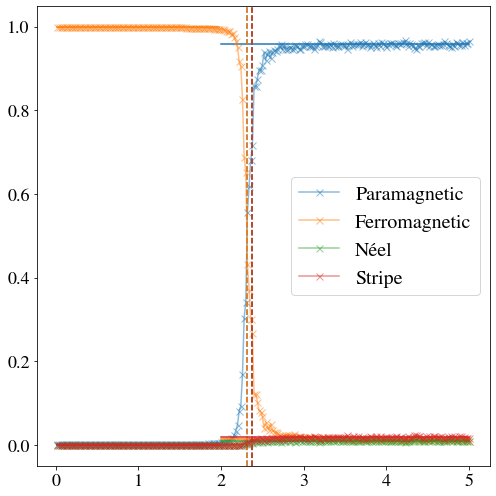

Prediction for 750 neurons in hidden layer
Lower bound (Paramagnetic): 0.00048630510049402
Higher bound (Paramagnetic): 0.9767150726972333
Half height (Paramagnetic): 0.48860068889886366
Critical temperature (Paramagnetic): 2.32
Lower bound (Ferromagnetic): 0.9994984483718862
Higher bound (Ferromagnetic): 0.00849349411243805
Half height (Ferromagnetic): 0.5039959712421621
Critical temperature (Ferromagnetic): 2.32
Lower bound (Néel): 7.16333250238676e-06
Higher bound (Néel): 0.007668669461207589
Half height (Néel): 0.003837916396854988
Critical temperature (Néel): 2.32
Lower bound (Stripe): 9.100084680540027e-06
Higher bound (Stripe): 0.00712272628922668
Half height (Stripe): 0.00356591318695361
Critical temperature (Stripe): 2.32


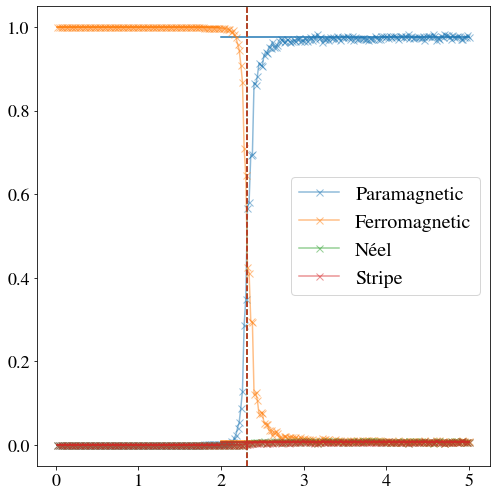

Prediction for 800 neurons in hidden layer
Lower bound (Paramagnetic): 0.000563265325035842
Higher bound (Paramagnetic): 0.9960323618907468
Half height (Paramagnetic): 0.4982978136078913
Critical temperature (Paramagnetic): 2.3000000000000003
Lower bound (Ferromagnetic): 0.999169467687605
Higher bound (Ferromagnetic): 0.0005670997620030098
Half height (Ferromagnetic): 0.49986828372480396
Critical temperature (Ferromagnetic): 2.3000000000000003
Lower bound (Néel): 4.410729765368161e-05
Higher bound (Néel): 0.0006388563642223059
Half height (Néel): 0.00034148183093799374
Critical temperature (Néel): 2.14
Lower bound (Stripe): 0.00022264700877708
Higher bound (Stripe): 0.0027616744559695963
Half height (Stripe): 0.0014921607323733382
Critical temperature (Stripe): 2.14


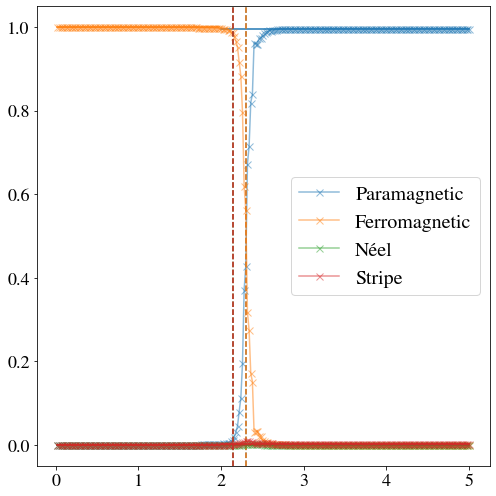

Prediction for 850 neurons in hidden layer
Lower bound (Paramagnetic): 0.00155864132102574
Higher bound (Paramagnetic): 0.977818975261565
Half height (Paramagnetic): 0.4896888082912954
Critical temperature (Paramagnetic): 2.3000000000000003
Lower bound (Ferromagnetic): 0.9983973038196529
Higher bound (Ferromagnetic): 0.0073109051194406765
Half height (Ferromagnetic): 0.5028541044695468
Critical temperature (Ferromagnetic): 2.3000000000000003
Lower bound (Néel): 1.3672462428075963e-05
Higher bound (Néel): 0.007015502607730761
Half height (Néel): 0.0035145875350794187
Critical temperature (Néel): 2.32
Lower bound (Stripe): 3.1175843687378816e-05
Higher bound (Stripe): 0.007854643022166694
Half height (Stripe): 0.003942909432927036
Critical temperature (Stripe): 2.32


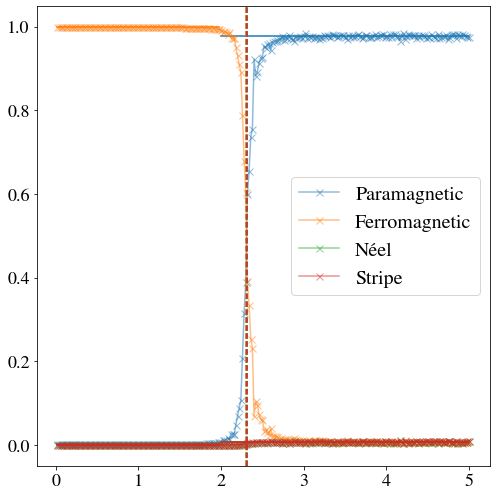

Prediction for 900 neurons in hidden layer
Lower bound (Paramagnetic): 0.001429273637477254
Higher bound (Paramagnetic): 0.987999466120028
Half height (Paramagnetic): 0.4947143698787526
Critical temperature (Paramagnetic): 2.3000000000000003
Lower bound (Ferromagnetic): 0.9985310518741576
Higher bound (Ferromagnetic): 0.0038621046001677817
Half height (Ferromagnetic): 0.5011965782371627
Critical temperature (Ferromagnetic): 2.3000000000000003
Lower bound (Néel): 3.816706775978673e-05
Higher bound (Néel): 0.004294143270757056
Half height (Néel): 0.0021661551692584214
Critical temperature (Néel): 2.28
Lower bound (Stripe): 2.361131228099109e-06
Higher bound (Stripe): 0.0038442521529527293
Half height (Stripe): 0.001923306642090414
Critical temperature (Stripe): 2.32


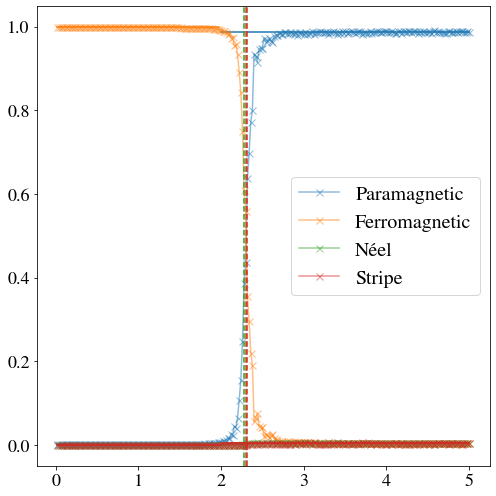

Prediction for 950 neurons in hidden layer
Lower bound (Paramagnetic): 0.001925234191585278
Higher bound (Paramagnetic): 0.9804447199783647
Half height (Paramagnetic): 0.491184977084975
Critical temperature (Paramagnetic): 2.3000000000000003
Lower bound (Ferromagnetic): 0.9979828548431352
Higher bound (Ferromagnetic): 0.005873240685711247
Half height (Ferromagnetic): 0.5019280477644232
Critical temperature (Ferromagnetic): 2.3000000000000003
Lower bound (Néel): 3.574658789148089e-05
Higher bound (Néel): 0.005172564673313174
Half height (Néel): 0.0026041556306023272
Critical temperature (Néel): 2.3000000000000003
Lower bound (Stripe): 5.610985237581191e-05
Higher bound (Stripe): 0.008509495448642102
Half height (Stripe): 0.004282802650508957
Critical temperature (Stripe): 3.66


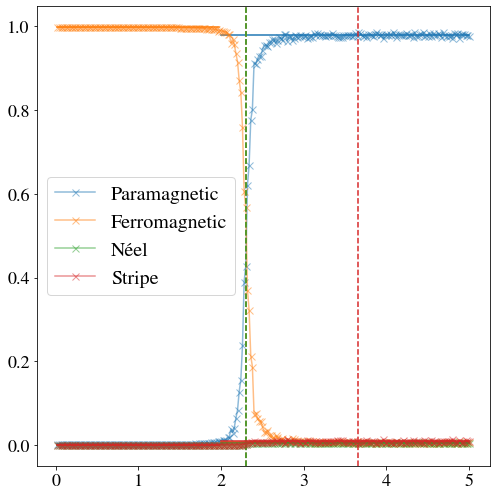

Prediction for 1000 neurons in hidden layer
Lower bound (Paramagnetic): 0.001205772161483712
Higher bound (Paramagnetic): 0.9692384904505489
Half height (Paramagnetic): 0.4852221313060163
Critical temperature (Paramagnetic): 2.3000000000000003
Lower bound (Ferromagnetic): 0.9987848079204533
Higher bound (Ferromagnetic): 0.006692720657129558
Half height (Ferromagnetic): 0.5027387642887915
Critical temperature (Ferromagnetic): 2.3000000000000003
Lower bound (Néel): 2.7107338428322788e-06
Higher bound (Néel): 0.01757738770994899
Half height (Néel): 0.00879004922189591
Critical temperature (Néel): 2.86
Lower bound (Stripe): 7.974050658958736e-06
Higher bound (Stripe): 0.006491357458450531
Half height (Stripe): 0.0032496657545547447
Critical temperature (Stripe): 2.32


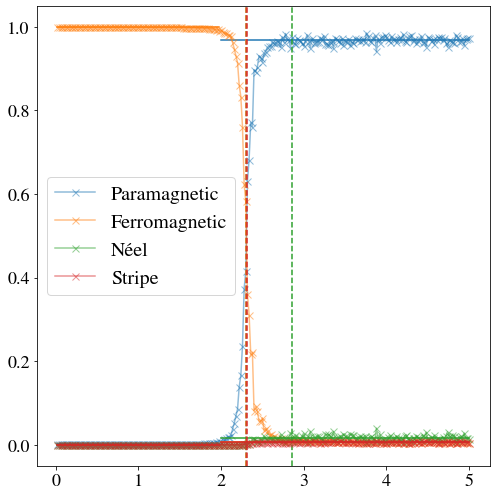

In [13]:
critical_temperature = []

for neuron in neurons:
	prediction = pd.read_csv(resultsfolder+f'/predictions_{neuron}.csv', header=0).to_numpy(float)
	print(f'Prediction for {neuron} neurons in hidden layer')

	temperature, para, ferro, neel, stripe = prediction[1:].T

	index_temp_1 = np.where(temperature == 1)[0][0]

	index_temp_3 = np.where(temperature == 4)[0][0]
	
	plt.figure(figsize=(7, 7))

	tc = []

	for index, feature in enumerate([para, ferro, neel, stripe]):
		color = colors[index]
		
		plt.plot(temperature, feature, 'x-', markerfacecolor=None, markersize=7, label = f'{names[index]}', color=color, alpha=0.5)

		popt_first, pcov_first = curve_fit(constant_func, temperature[:index_temp_1+1], feature[:index_temp_1+1])
		popt_last, pcov_last = curve_fit(constant_func, temperature[index_temp_3:], feature[index_temp_3:])

		plt.plot(temperature[:(np.where(temperature == 2)[0][0])], 
			constant_func(temperature[:(np.where(temperature == 2)[0][0])], *popt_first), color=color)

		plt.plot(temperature[(np.where(temperature == 2)[0][0]):], 
			constant_func(temperature[(np.where(temperature == 2)[0][0]):], *popt_last), color=color)
		
		print(f'Lower bound ({names[index]}): {popt_first[0]}')
		print(f'Higher bound ({names[index]}): {popt_last[0]}')
		
		half_of_height = (popt_first[0]+popt_last[0])/2
		
		closest_index = np.abs(feature - half_of_height *np.ones_like(feature)).argmin()

		closest_x = temperature[closest_index]

		plt.axvline(x=closest_x, color = color, linestyle = '--')
		
		print(f'Half height ({names[index]}): {half_of_height}')
		print(f'Critical temperature ({names[index]}): {closest_x}')
		tc.append(closest_x)
		
	plt.legend()
	plt.savefig(os.path.join(saving_folder, f'critical_temperature_{neuron}.pdf'))
	plt.show()

	mean_temperature = np.mean(tc)

	# finding an outlier:
	probably_outlier = np.abs(tc - mean_temperature).max()
	probably_outlier = probably_outlier/np.mean(tc)

	probably_outlier_index = np.abs(tc - mean_temperature).argmax()

	if probably_outlier>0.1:
		tc.remove(tc[probably_outlier_index])

	mean_temperature = np.mean(tc)

	critical_temperature.append(mean_temperature)

In [14]:
critical_temperature

[2.085,
 2.473333333333333,
 2.22,
 2.493333333333333,
 2.3449999999999998,
 2.355,
 2.52,
 2.45,
 2.37,
 2.3850000000000002,
 2.495,
 2.385,
 2.615,
 2.38,
 2.315,
 2.48,
 2.3449999999999998,
 2.32,
 2.38,
 2.3099999999999996,
 2.393333333333333,
 2.2649999999999997,
 2.21,
 2.29,
 2.22,
 2.385,
 2.3499999999999996,
 2.32,
 2.22,
 2.31,
 2.3000000000000003,
 2.3000000000000003,
 2.3066666666666666]

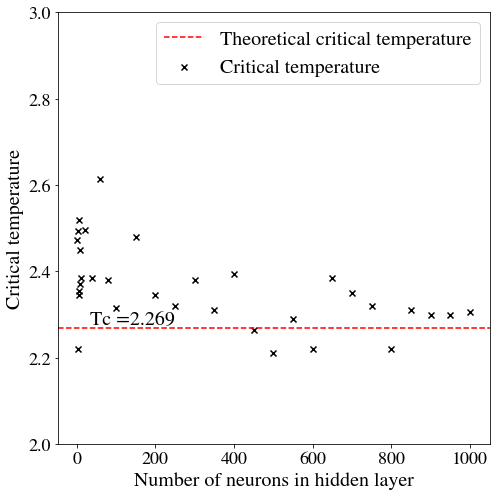

In [15]:
plt.figure(figsize=(7, 7))


plt.scatter(neurons[1:], critical_temperature[1:], marker='x', color='black', label='Critical temperature') # excluding the first neuron
plt.axhline(y=2.269, color = 'red', linestyle = '--', label = 'Theoretical critical temperature')

plt.xlabel('Number of neurons in hidden layer')
plt.ylabel('Critical temperature')

plt.text(250, 2.269, rf'Tc ={2.269}', color='black', 
        verticalalignment='bottom', horizontalalignment='right', fontsize=20)

plt.ylim((2, 3))
plt.legend()
plt.savefig(os.path.join(saving_folder, 'critical_temperature.pdf'))
plt.show()

# Only using the critical temperature gotten for Ferromagnetic and Paramagnetic

In [ ]:
def constant_func(x, b):
    return np.full_like(x, b)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

names = ['Paramagnetic', 'Ferromagnetic', 'Néel', 'Stripe']

critical_temperature = []

for neuron in neurons:
	prediction = pd.read_csv(resultsfolder+f'/predictions_{neuron}.csv', header=0).to_numpy(float)
	print(f'Prediction for {neuron} neurons in hidden layer')

	temperature, para, ferro, neel, stripe = prediction[1:].T

	index_temp_1 = np.where(temperature == 1)[0][0]

	index_temp_3 = np.where(temperature == 4)[0][0]
	
	plt.figure(figsize=(7, 7))

	tc = []

	for index, feature in enumerate([para, ferro]):
		color = colors[index]
		
		plt.plot(temperature, feature, 'x-', markerfacecolor=None, markersize=7, label = f'{names[index]}', color=color, alpha=0.5)

		popt_first, pcov_first = curve_fit(constant_func, temperature[:index_temp_1+1], feature[:index_temp_1+1])
		popt_last, pcov_last = curve_fit(constant_func, temperature[index_temp_3:], feature[index_temp_3:])

		plt.plot(temperature[:(np.where(temperature == 2)[0][0])], 
			constant_func(temperature[:(np.where(temperature == 2)[0][0])], *popt_first), color=color)

		plt.plot(temperature[(np.where(temperature == 2)[0][0]):], 
			constant_func(temperature[(np.where(temperature == 2)[0][0]):], *popt_last), color=color)
		
		print(f'Lower bound ({names[index]}): {popt_first[0]}')
		print(f'Higher bound ({names[index]}): {popt_last[0]}')
		
		half_of_height = (popt_first[0]+popt_last[0])/2
		
		closest_index = np.abs(feature - half_of_height *np.ones_like(feature)).argmin()

		closest_x = temperature[closest_index]

		plt.axvline(x=closest_x, color = color, linestyle = '--')
		
		print(f'Half height ({names[index]}): {half_of_height}')
		print(f'Critical temperature ({names[index]}): {closest_x}')
		tc.append(closest_x)
		
	plt.legend()
	plt.savefig(os.path.join(saving_folder, f'(using only Ferro and Para) critical_temperature_{neuron}.pdf'))
	plt.show()

	mean_temperature = np.mean(tc)

	critical_temperature.append(mean_temperature)